# EECE5644-Assignment-4
### Venkata Buddha Work

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import numpy as np
from scipy.stats import norm, multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import KFold
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage.io import imread
from sklearn.metrics import pairwise_distances

np.set_printoptions(suppress=True)
np.random.seed(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

Text(0.5, 1.0, 'Plane Color')

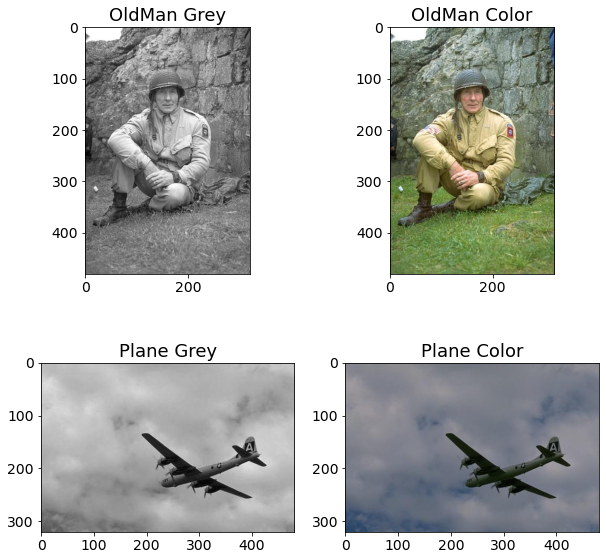

In [4]:
oldman_gray = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/gray/376043.jpg')
oldman_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/376043.jpg')
plane_gray = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/gray/3096.jpg')
plane_color = imread('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/BSDS300/html/images/plain/normal/color/3096.jpg')
images = [oldman_gray, oldman_color, plane_gray, plane_color]

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(oldman_gray, cmap=plt.cm.gray)
ax[0,0].set_title("OldMan Grey")
ax[0,1].imshow(oldman_color)
ax[0,1].set_title("OldMan Color")
ax[1,0].imshow(plane_gray, cmap=plt.cm.gray)
ax[1,0].set_title("Plane Grey")
ax[1,1].imshow(plane_color)
ax[1,1].set_title("Plane Color")

In [5]:
def normalize_by_col(arr):
    norm_arr = np.empty((np.size(arr,0), np.size(arr,1))) #normalized array initialized
    
    for i in range(np.size(features,1)):
        norm = (arr[:,i] - np.min(arr[:,i]))/(np.max(arr[:,i]) - np.min(arr[:,i]))
        norm_arr[:,i] = norm
    return norm_arr

In [6]:
def generate_feature_vector(image):
    # Load image, get its dimensions
    image_np = np.array(image)
    # Return an array of the row and column indices of the image (height and width)
    img_indices = np.indices((image_np.shape[0], image_np.shape[1]))
        
    # Set up data array to store features: row ind, col ind, [num_channels]
    # num_channels = 1 for grayscale and 3 for RGB
    if image_np.ndim == 2:  # Grayscale image
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), image_np.flatten()])
        # Find ranges of features as max - min
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    elif image_np.ndim == 3: # Color image with RGB values
        # Create the features matrix of row and col indices, plus pixel values
        features = np.array([img_indices[0].flatten(), img_indices[1].flatten(), 
                             image_np[..., 0].flatten(), image_np[..., 1].flatten(), image_np[..., 2].flatten()])
        min_f = np.min(features, axis=1)
        max_f = np.max(features, axis=1)
        ranges = max_f - min_f
        # Each feature normalized to the unit interval [0,1] using max-min normalization: (x - min) / (max - min) 
        # New axis np.newaxis to allow numpy broadcasting
        # np.diag(1/ranges) to perform the division operation in matrix form
        normalized_data = np.diag(1 / ranges).dot(features - min_f[:, np.newaxis])
    else:
        print("Incorrect image dimensions for feature vector")
        
    # Returns feature vector of normalized pixels as shape (height*width, 3 or 5)
    return image_np, normalized_data.T

In [7]:
def kFoldGMM(test_clusters, x_train):

    #Find certain parameters 
    K = 10
    n_clusters = np.max(test_clusters)
    avg_ll_per_fold = np.empty((K)) # Allocate space for probability error train error array - percep * 10
    avg_ll_per_it = np.empty((n_clusters))

    kf = KFold(n_splits=K, shuffle=True) 
    q = 0
    for cluster in test_clusters:
        k = 0
        for train_indices, valid_indices in kf.split(x_train):
            x_train_k = x_train[train_indices]
            x_valid_k = x_train[valid_indices]
            # Train model parameters
            gmm = GaussianMixture(n_components=cluster, init_params='kmeans', n_init=10, max_iter=400, tol=1e-3).fit(x_train_k)
            Z = -gmm.score_samples(x_valid_k)
            avg_ll_per_fold[k] = np.mean(Z) #records the avg ll over each fold
            k += 1
        avg_ll_per_it[q] = np.mean(avg_ll_per_fold) #records avg ll over each cluster
        print("cluster ", q)
        q += 1
            
    max_avg_ll = np.min(avg_ll_per_it) #records max avg ll (or min negative ll) over all the clusters and folds
    cluster_num = np.argmin(avg_ll_per_it)
    
    return max_avg_ll, cluster_num, avg_ll_per_it

In [8]:
def k_means_clustering(X, K, plot=True):
    # Initialize K cluster centroids (K, n) as random values in data space
    centroids = np.random.rand(K, X.shape[1])

    # Convergence when values no longer change, can compare centroids
    converged = False
    # K-means iteration index
    t = 0
    while not converged:
        centroids_prev = centroids

        # Compute pairwise distance to centers
        # dist is of shape (N,K) where dist[i, j] is the Euclidean distance between sample x[i] and centroid mu[j]
        dist = pairwise_distances(X, centroids, metric='euclidean')

        # Step 1: Assign cluster labels to samples
        c = np.argmin(dist, axis=1)

        # Step 2: Move cluster centroids to mean of points assigned to it
        centroids = np.array([np.mean(X[c == k], axis=0) for k in range(K)])

        # Check for convergence
        converged = np.array_equal(centroids, centroids_prev)
        # Update loop iteration
        t += 1
    
    return c

In [14]:
#For each pixel, generate a 5-dimensional feature vector as follows: (1) append row index,
#column index, red value, green value, blue value for each pixel into a raw feature vector;
#(2) normalize each feature entry individually to the interval [0,1], so that all of the feature
#vectors representing every pixel in an image fit into the 5-dimensional unit-hypercube.
#im = Image.open(r'C:\Users\Dinesh\Downloads\HW4.jpg')
im = Image.open(r'C:\Users\Dinesh\Downloads\HW4.plane.jpg')
width, height = im.size
pixel_values = list(im.getdata())
pixel_ct = width*height # (old: 481 x 321) - downsized to 120 x 80
image_np = np.array(im)

features = np.empty((pixel_ct, 5))
j = 0 #to find col
for i in range(pixel_ct):
    if j >= width:
        j = 0
    features[i,0] = i//width #row - starts at row 0
    features[i,1] = j #column - starts at col 0
    temp = np.array(pixel_values[i])
    features[i,2] = temp[0] #R
    features[i,3] = temp[1] #G
    features[i,4] = temp[2] #B
    j += 1  
norm_feat = normalize_by_col(features)

cluster  0
cluster  1
cluster  2
cluster  3
cluster  4
cluster  5
cluster  6
cluster  7
cluster  8
cluster  9
cluster  10
cluster  11
cluster  12
cluster  13
cluster  14
cluster  15
cluster  16
cluster  17
cluster  18
Max Average Log-Likelihood:  -8.877831591156285
Cluster with Max Average Log-Likelihood:  19


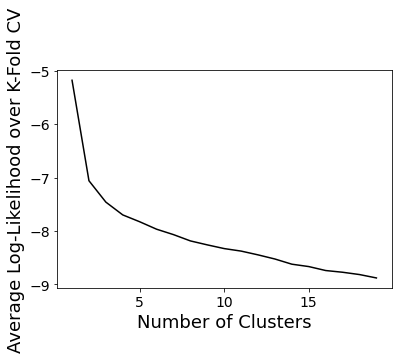

In [15]:
#Fit a Gaussian Mixture Model (GMM) to these normalized feature vectors representing the pixels of the image.
#To fit the GMM, use maximum likelihood parameter estimation (e.g., via Expectation Maximisation - see link)
#and 10-fold cross-validation (with maximum average validation-log-likelihood as the objective) for model order selection
test_clusters = np.arange(1, 20, 1) #1-20 in increments of 1
max_avg_ll, best_cluster, all_ll = kFoldGMM(test_clusters, norm_feat)
print("Max Average Log-Likelihood: ", max_avg_ll)
print("Cluster with Max Average Log-Likelihood: ", best_cluster+1)
fig = plt.figure()
plt.plot(test_clusters,all_ll, c='k')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Log-Likelihood over K-Fold CV")
plt.show()
best_cluster = 6

Text(0.5, 1.0, 'Clustering with K = 6')

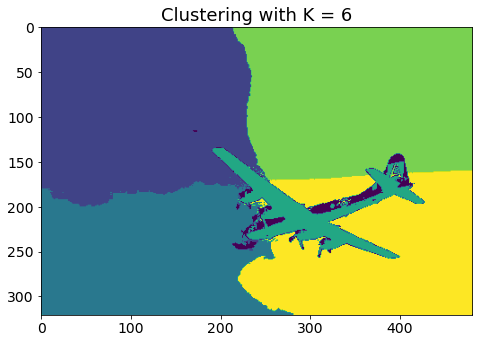

In [18]:
#Once you have identified the best GMM for your feature vectors, assign the most likely component label to
#each pixel by evaluating component label posterior probabilities for each feature vector according to your GMM.
labels = k_means_clustering(norm_feat, best_cluster,plot=True)
labels_img = labels.reshape(image_np.shape[0], image_np.shape[1]) # Assigned segment labels reshaped into an image to color-code pixels
     
#Present the original image and your GMM-based segmentation labels assigned to each pixel side by side for easy
#visual assessment of your segmentation outcome
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(labels_img)
ax.set_title("Clustering with K = {}".format(best_cluster))